In [45]:
import os
import re
import tempfile

from joblib import Parallel, delayed
import numpy as np
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt
from nistats.hemodynamic_models import glover_hrf
from brainiak.utils import fmrisim
from scipy.signal import convolve, resample
from nibetaseries.interfaces.nistats import LSABetaSeries, LSSBetaSeries


In [22]:
TR = 2
N_VOLS = 471
EXAMPLE_EVENTS_FILE = os.path.abspath('../../sub-GE120003/ses-pre/func/sub-GE120003_ses-pre_task-taskswitch_events.tsv')
EVENT_DURATION = 1.5
N_VOXELS = 2

In [3]:
events_df = pd.read_csv(EXAMPLE_EVENTS_FILE, sep='\t')
events_df.head()

,trial_type,switch,onset,correct,response_time,stimulus,block,duration,color
0,single,0,38.042,1,0.994,1,1,1.5,blue
1,single,0,44.055,1,0.820,8,1,1.5,blue
2,single,0,48.565,1,0.687,9,1,1.5,blue
3,single,0,54.077,1,0.554,3,1,1.5,blue
4,single,0,57.083,1,0.593,1,1,1.5,blue


In [4]:
n_events = events_df['trial_type'].value_counts()
single_n_events = n_events['single']
repeat_n_events = n_events['repeat']
switch_n_events = n_events['switch']
firsttrial_n_events = n_events['firsttrial']

In [5]:
switch_cov = np.array([[1, 0.9], [0.9, 1]])
repeat_cov = single_cov = np.array([[1, 0.0], [0.0, 1]])

# two voxels
gnd_means = np.array([1, 1])

event_betas = {"single": None, "repeat": None, "switch": None}

event_betas['single'] = np.random.multivariate_normal(
    gnd_means,
    single_cov,
    size=(single_n_events),
    tol=0.00005
)

event_betas['repeat'] = np.random.multivariate_normal(
    gnd_means,
    repeat_cov,
    size=(repeat_n_events),
    tol=0.00005
)

event_betas['switch'] = np.random.multivariate_normal(
    gnd_means,
    switch_cov,
    size=(switch_n_events),
    tol=0.00005
)

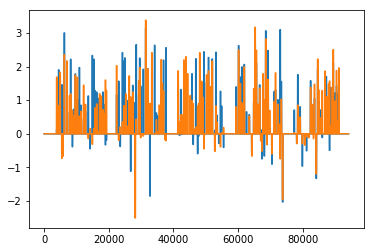

In [6]:
TEMP_RES = 100
stim_func_total = np.zeros((TR * N_VOLS * TEMP_RES, N_VOXELS))
for voxel in range(N_VOXELS):
    for trial_type in ["single", "repeat", "switch"]:
        trial_type_df = events_df[events_df['trial_type'] == trial_type]

        stim_func = fmrisim.generate_stimfunction(
                        onsets=list(trial_type_df["onset"]),
                        # the weights are the beta series
                        weights=list(event_betas[trial_type][:, voxel]),
                        event_durations=list(trial_type_df["duration"]),
                        total_time=N_VOLS * TR,
                        temporal_resolution=TEMP_RES,
                    )
        stim_func_total[:, voxel] += stim_func.flatten()
plt.plot(stim_func_total) 

In [7]:
hrf = glover_hrf(TR, oversampling=TEMP_RES*TR)

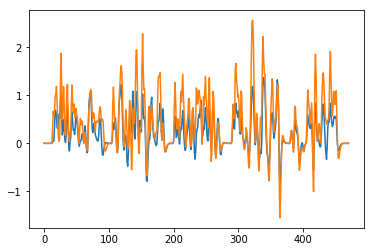

In [8]:
# concolve the hrf over the stimuli and downsample time back to TR
simulated_brain = resample(convolve(stim_func_total, np.array([hrf, hrf]).T, mode='same'), N_VOLS)
plt.plot(simulated_brain)

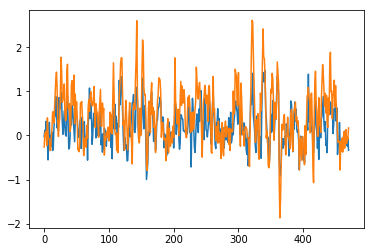

In [9]:
std = simulated_brain.std()
mult = 0.5
noise = np.random.normal(0, scale=std * mult, size=simulated_brain.shape)
simulated_brain = simulated_brain + noise
plt.plot(simulated_brain)

In [10]:
simulated_brain_img = nib.Nifti1Image(np.array([[simulated_brain.T]]), affine=np.eye(4))
simulated_brain_mask = nib.Nifti1Image(np.ones(simulated_brain_img.shape[:-1]), affine=np.eye(4))

In [30]:
template = r".*desc-([A-Za-z0-9]+)_betaseries.nii.gz"
re.match(template, lss_res.outputs.beta_maps[0]).groups()[0]

'single'

In [34]:
with tempfile.TemporaryDirectory() as lss_outdir:
    cwd = os.getcwd()

    os.chdir(lss_outdir)
    try:
        lss = LSSBetaSeries(
        bold_file=simulated_brain_img,
        bold_metadata={"RepetitionTime": 2},
        events_file=EXAMPLE_EVENTS_FILE,
        hrf_model='glover',
        high_pass=0.0,
        mask_file=simulated_brain_mask,
        selected_confounds=None,
        smoothing_kernel=None)

        lss_res = lss.run()
    finally:
        os.chdir(cwd)
    
    template = r".*desc-([A-Za-z0-9]+)_betaseries.nii.gz"
    
    lss_corrs = {}
    for bs_map in lss_res.outputs.beta_maps:
        mtch = re.match(template, bs_map).groups()[0]
        
        lss_corrs[mtch] = np.corrcoef(nib.load(bs_map).get_fdata().squeeze())[0, 1]

        


/home/jdkent/.conda/envs/aim1_valid/lib/python3.7/site-packages/nibetaseries/interfaces/nistats.py:78: DeprecationWarning: The parameter "mask" will be removed in next release of Nistats. Please use the parameter "mask_img" instead.
  minimize_memory=False,
Computing run 1 out of 1 runs (go take a coffee, a big one)

Computation of 1 runs done in 0 seconds

/home/jdkent/.conda/envs/aim1_valid/lib/python3.7/site-packages/nistats/regression.py:339: FutureWarning: 'resid' from RegressionResults has been deprecated and will be removed. Please use 'residuals' instead.
  FutureWarning,
Computing run 1 out of 1 runs (go take a coffee, a big one)

Computation of 1 runs done in 0 seconds

Computing run 1 out of 1 runs (go take a coffee, a big one)

Computation of 1 runs done in 0 seconds

Computing run 1 out of 1 runs (go take a coffee, a big one)

Computation of 1 runs done in 0 seconds

Computing run 1 out of 1 runs (go take a coffee, a big one)

Computation of 1 runs done in 0 seconds

Compu


Computation of 1 runs done in 0 seconds

Computing run 1 out of 1 runs (go take a coffee, a big one)

Computation of 1 runs done in 0 seconds

Computing run 1 out of 1 runs (go take a coffee, a big one)

Computation of 1 runs done in 0 seconds

Computing run 1 out of 1 runs (go take a coffee, a big one)

Computation of 1 runs done in 0 seconds

Computing run 1 out of 1 runs (go take a coffee, a big one)

Computation of 1 runs done in 0 seconds

Computing run 1 out of 1 runs (go take a coffee, a big one)

Computation of 1 runs done in 0 seconds

Computing run 1 out of 1 runs (go take a coffee, a big one)

Computation of 1 runs done in 0 seconds

Computing run 1 out of 1 runs (go take a coffee, a big one)

Computation of 1 runs done in 0 seconds

Computing run 1 out of 1 runs (go take a coffee, a big one)

Computation of 1 runs done in 0 seconds

Computing run 1 out of 1 runs (go take a coffee, a big one)

Computation of 1 runs done in 0 seconds

Computing run 1 out of 1 runs (go take a

In [35]:
lss_corrs

{'single': 0.6074551098948903,
 'firsttrial': 0.7771666802005046,
 'switch': 0.7147244218506225,
 'repeat': 0.6405756596708772}

In [12]:
lsa_outdir = tempfile.mkdtemp(prefix='sim_')

os.chdir(lsa_outdir)
try:
    lsa = LSABetaSeries(
    bold_file=simulated_brain_img,
    bold_metadata={"RepetitionTime": 2},
    events_file=EXAMPLE_EVENTS_FILE,
    hrf_model='glover',
    high_pass=0.08,
    mask_file=simulated_brain_mask,
    selected_confounds=None,
    smoothing_kernel=None)

    lsa_res = lsa.run()
finally:
    os.chdir(cwd)

/home/jdkent/.conda/envs/aim1_valid/lib/python3.7/site-packages/nibetaseries/interfaces/nistats.py:203: DeprecationWarning: The parameter "mask" will be removed in next release of Nistats. Please use the parameter "mask_img" instead.
  minimize_memory=False,
Computing run 1 out of 1 runs (go take a coffee, a big one)

Computation of 1 runs done in 4 seconds

/home/jdkent/.conda/envs/aim1_valid/lib/python3.7/site-packages/nistats/regression.py:339: FutureWarning: 'resid' from RegressionResults has been deprecated and will be removed. Please use 'residuals' instead.
  FutureWarning,


In [13]:
# load switch and repeat beta series images
lss_switch = nib.load('./outputs/lss/desc-switch_betaseries.nii.gz')
lss_repeat = nib.load('./outputs/lss/desc-repeat_betaseries.nii.gz')
lss_single = nib.load('./outputs/lss/desc-single_betaseries.nii.gz')

lsa_switch = nib.load('./outputs/lsa/desc-switch_betaseries.nii.gz')
lsa_repeat = nib.load('./outputs/lsa/desc-repeat_betaseries.nii.gz')
lsa_single = nib.load('./outputs/lsa/desc-single_betaseries.nii.gz')

In [14]:
np.corrcoef(lsa_single.get_fdata().squeeze())

array([[1.        , 0.39423509],
       [0.39423509, 1.        ]])

In [15]:
np.corrcoef(lsa_switch.get_fdata().squeeze())

array([[1.       , 0.3911161],
       [0.3911161, 1.       ]])

In [16]:
np.corrcoef(lsa_repeat.get_fdata().squeeze())

array([[1.       , 0.2834928],
       [0.2834928, 1.       ]])

In [17]:
np.corrcoef(lss_single.get_fdata().squeeze())

array([[1.        , 0.60745511],
       [0.60745511, 1.        ]])

In [18]:
np.corrcoef(lss_switch.get_fdata().squeeze())

array([[1.        , 0.71472442],
       [0.71472442, 1.        ]])

In [19]:
np.corrcoef(lss_repeat.get_fdata().squeeze())

array([[1.        , 0.64057566],
       [0.64057566, 1.        ]])

In [55]:
def simulate_session(rng, noise_ratio=1):
    TR = 2
    N_VOLS = 471
    EXAMPLE_EVENTS_FILE = os.path.abspath('../../sub-GE120003/ses-pre/func/sub-GE120003_ses-pre_task-taskswitch_events.tsv')
    EVENT_DURATION = 1.5
    N_VOXELS = 2
    
    events_df = pd.read_csv(EXAMPLE_EVENTS_FILE, sep='\t')
    
    n_events = events_df['trial_type'].value_counts()
    single_n_events = n_events['single']
    repeat_n_events = n_events['repeat']
    switch_n_events = n_events['switch']
    firsttrial_n_events = n_events['firsttrial']
    
    switch_cov = np.array([[1, 0.9], [0.9, 1]])
    repeat_cov = single_cov = np.array([[1, 0.0], [0.0, 1]])

    # two voxels
    gnd_means = np.array([1, 1])

    event_betas = {"single": None, "repeat": None, "switch": None}

    event_betas['single'] = rng.multivariate_normal(
        gnd_means,
        single_cov,
        size=(single_n_events),
        tol=0.00005
    )

    event_betas['repeat'] = rng.multivariate_normal(
        gnd_means,
        repeat_cov,
        size=(repeat_n_events),
        tol=0.00005
    )

    event_betas['switch'] = rng.multivariate_normal(
        gnd_means,
        switch_cov,
        size=(switch_n_events),
        tol=0.00005
    )
    
    TEMP_RES = 100
    stim_func_total = np.zeros((TR * N_VOLS * TEMP_RES, N_VOXELS))
    for voxel in range(N_VOXELS):
        for trial_type in event_betas:
            trial_type_df = events_df[events_df['trial_type'] == trial_type]

            stim_func = fmrisim.generate_stimfunction(
                            onsets=list(trial_type_df["onset"]),
                            # the weights are the beta series
                            weights=list(event_betas[trial_type][:, voxel]),
                            event_durations=list(trial_type_df["duration"]),
                            total_time=N_VOLS * TR,
                            temporal_resolution=TEMP_RES,
                        )
            stim_func_total[:, voxel] += stim_func.flatten()
            
    hrf = glover_hrf(TR, oversampling=TEMP_RES * TR)
    
    simulated_brain = resample(convolve(stim_func_total, np.array([hrf, hrf]).T, mode='same'), N_VOLS)
    
    std = simulated_brain.std()
    if noise_ratio > 0:
        noise = np.random.normal(0, scale=std * noise_ratio, size=simulated_brain.shape)
        simulated_brain = simulated_brain + noise
    
    simulated_brain_img = nib.Nifti1Image(np.array([[simulated_brain.T]]), affine=np.eye(4))
    simulated_brain_mask = nib.Nifti1Image(np.ones(simulated_brain_img.shape[:-1]), affine=np.eye(4))
    
    
    cwd = os.getcwd()
    with tempfile.TemporaryDirectory() as lss_outdir:

        os.chdir(lss_outdir)
        try:
            lss = LSSBetaSeries(
            bold_file=simulated_brain_img,
            bold_metadata={"RepetitionTime": 2},
            events_file=EXAMPLE_EVENTS_FILE,
            hrf_model='glover',
            high_pass=0.0,
            mask_file=simulated_brain_mask,
            selected_confounds=None,
            smoothing_kernel=None)

            lss_res = lss.run()
        finally:
            os.chdir(cwd)

        template = r".*desc-([A-Za-z0-9]+)_betaseries.nii.gz"

        lss_corrs = {}
        for bs_map in lss_res.outputs.beta_maps:
            mtch = re.match(template, bs_map).groups()[0]

            lss_corrs[mtch] = np.corrcoef(nib.load(bs_map).get_fdata().squeeze())[0, 1]
    
    with tempfile.TemporaryDirectory() as lsa_outdir:
        cwd = os.getcwd()

        os.chdir(lsa_outdir)
        try:
            lsa = LSABetaSeries(
            bold_file=simulated_brain_img,
            bold_metadata={"RepetitionTime": 2},
            events_file=EXAMPLE_EVENTS_FILE,
            hrf_model='glover',
            high_pass=0.0,
            mask_file=simulated_brain_mask,
            selected_confounds=None,
            smoothing_kernel=None)

            lsa_res = lsa.run()
        finally:
            os.chdir(cwd)

        template = r".*desc-([A-Za-z0-9]+)_betaseries.nii.gz"

        lsa_corrs = {}
        for bs_map in lsa_res.outputs.beta_maps:
            mtch = re.match(template, bs_map).groups()[0]

            lsa_corrs[mtch] = np.corrcoef(nib.load(bs_map).get_fdata().squeeze())[0, 1]

    
    output_dict = {'lsa': lsa_corrs, 'lss': lss_corrs}
    
    return output_dict

In [53]:
# rng = np.random.RandomState(0)
iterations = 1000
args = [(np.random.RandomState(n), 1) for n in range(iterations)]
result_collector = Parallel(n_jobs=32)(delayed(simulate_session)(rng, noise_ratio) for rng, noise_ratio in args)

In [54]:
diff_dict = {'estimator': [], 'event_contrast': [], 'block_contrast': []}
for rdict in result_collector:
    lsa_event_contrast = rdict['lsa']['switch'] - rdict['lsa']['repeat']
    lsa_block_contrast = rdict['lsa']['repeat'] - rdict['lsa']['single']
    
    lss_event_contrast = rdict['lss']['switch'] - rdict['lss']['repeat']
    lss_block_contrast = rdict['lss']['repeat'] - rdict['lss']['single']
    
    diff_dict['estimator'].append('lsa')
    diff_dict['event_contrast'].append(lsa_event_contrast)
    diff_dict['block_contrast'].append(lsa_block_contrast)
    
    diff_dict['estimator'].append('lss')
    diff_dict['event_contrast'].append(lss_event_contrast)
    diff_dict['block_contrast'].append(lss_block_contrast)
    
diff_df = pd.DataFrame.from_dict(diff_dict)
diff_df.groupby('estimator').describe()

event_contrast                                                    \
                   count      mean       std       min       25%       50%   
estimator                                                                    
lsa               1000.0  0.048384  0.162598 -0.585630 -0.051397  0.049669   
lss               1000.0 -0.019608  0.152540 -0.507556 -0.117828 -0.016551   

                             block_contrast                                \
                75%      max          count      mean       std       min   
estimator                                                                   
lsa        0.156536  0.57852         1000.0  0.023878  0.168881 -0.453378   
lss        0.082350  0.44258         1000.0  0.092281  0.152294 -0.403578   

                                                   
                25%       50%       75%       max  
estimator                                          
lsa       -0.094895  0.021522  0.141066  0.505617  
lss       -0.010822  0.093302  0.198135  0.646686

In [56]:
# rng = np.random.RandomState(0)
iterations = 1000
args = [(np.random.RandomState(n), 0) for n in range(iterations)]
result_collector = Parallel(n_jobs=32)(delayed(simulate_session)(rng, noise_ratio) for rng, noise_ratio in args)

In [57]:
diff_no_noise_dict = {'estimator': [], 'event_contrast': [], 'block_contrast': []}
for rdict in result_collector:
    lsa_event_contrast = rdict['lsa']['switch'] - rdict['lsa']['repeat']
    lsa_block_contrast = rdict['lsa']['repeat'] - rdict['lsa']['single']
    
    lss_event_contrast = rdict['lss']['switch'] - rdict['lss']['repeat']
    lss_block_contrast = rdict['lss']['repeat'] - rdict['lss']['single']
    
    diff_no_noise_dict['estimator'].append('lsa')
    diff_no_noise_dict['event_contrast'].append(lsa_event_contrast)
    diff_no_noise_dict['block_contrast'].append(lsa_block_contrast)
    
    diff_no_noise_dict['estimator'].append('lss')
    diff_no_noise_dict['event_contrast'].append(lss_event_contrast)
    diff_no_noise_dict['block_contrast'].append(lss_block_contrast)
    
diff_no_noise_df = pd.DataFrame.from_dict(diff_no_noise_dict)
diff_no_noise_df.groupby('estimator').describe()

event_contrast                                                    \
                   count      mean       std       min       25%       50%   
estimator                                                                    
lsa               1000.0  0.016784  0.066213 -0.283265 -0.024760  0.017937   
lss               1000.0  0.007524  0.062565 -0.278956 -0.029776  0.009975   

                              block_contrast                                \
                75%       max          count      mean       std       min   
estimator                                                                    
lsa        0.059692  0.281470         1000.0  0.079852  0.074334 -0.129016   
lss        0.048657  0.180759         1000.0  0.090161  0.088516 -0.166042   

                                                   
                25%       50%       75%       max  
estimator                                          
lsa        0.031286  0.078448  0.125969  0.360469  
lss        0.027648  0.084918  0.147021  0.393159

In [58]:
# rng = np.random.RandomState(0)
iterations = 1000
args = [(np.random.RandomState(n), 0.5) for n in range(iterations)]
result_collector = Parallel(n_jobs=32)(delayed(simulate_session)(rng, noise_ratio) for rng, noise_ratio in args)

In [60]:
diff_half_noise_dict = {'estimator': [], 'event_contrast': [], 'block_contrast': []}
for rdict in result_collector:
    lsa_event_contrast = rdict['lsa']['switch'] - rdict['lsa']['repeat']
    lsa_block_contrast = rdict['lsa']['repeat'] - rdict['lsa']['single']
    
    lss_event_contrast = rdict['lss']['switch'] - rdict['lss']['repeat']
    lss_block_contrast = rdict['lss']['repeat'] - rdict['lss']['single']
    
    diff_half_noise_dict['estimator'].append('lsa')
    diff_half_noise_dict['event_contrast'].append(lsa_event_contrast)
    diff_half_noise_dict['block_contrast'].append(lsa_block_contrast)
    
    diff_half_noise_dict['estimator'].append('lss')
    diff_half_noise_dict['event_contrast'].append(lss_event_contrast)
    diff_half_noise_dict['block_contrast'].append(lss_block_contrast)
    
diff_half_noise_df = pd.DataFrame.from_dict(diff_half_noise_dict)
diff_half_noise_df.groupby('estimator').describe()

event_contrast                                                    \
                   count      mean       std       min       25%       50%   
estimator                                                                    
lsa               1000.0  0.034904  0.108930 -0.355875 -0.040574  0.037238   
lss               1000.0 -0.009055  0.116529 -0.435085 -0.081599 -0.004039   

                              block_contrast                               \
                75%       max          count      mean       std      min   
estimator                                                                   
lsa        0.106640  0.381451         1000.0  0.057718  0.118605 -0.32577   
lss        0.066322  0.469026         1000.0  0.094616  0.126732 -0.36366   

                                                   
                25%       50%       75%       max  
estimator                                          
lsa       -0.020635  0.061408  0.133430  0.491193  
lss        0.009561  0.092399  0.175477  0.481891

These simulations suggest LSS is better for detecting differences that are between blocks than are within blocks, 
where LSA has the advantage for event related contrasts.